In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/media/hayk/ecf060ce-bc56-4885-9176-43d514db6c66/pac"))

# Any results you write to the current directory are saved as output.

['test_set.csv.zip', 'test_set_sample.csv', 'test_set_metadata.csv', 'test_set_metadata.csv.zip', 'test_set_sample.csv.zip', 'training_set_metadata.csv', 'data_note.pdf', 'training_set.csv', 'data_note.pdf.zip', 'training_set.csv.zip', 'test_set.csv']


In [6]:
%matplotlib inline

import os
from collections import Counter, OrderedDict
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from astropy.table import Table
import multiprocessing
from cesium.time_series import TimeSeries
import cesium.featurize as featurize
from tqdm import tnrange, tqdm_notebook
import sklearn 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [7]:
pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'Y')])

# it also helps to have passbands associated with a color
pbcols = OrderedDict([(0,'blueviolet'), (1,'green'), (2,'red'),\
                      (3,'orange'), (4, 'black'), (5, 'brown')])

pbnames = list(pbmap.values())

In [8]:
datadir = '/media/hayk/ecf060ce-bc56-4885-9176-43d514db6c66/pac'
metafilename = os.path.join(datadir, 'training_set_metadata.csv')
print(metafilename)

metadata = Table.read(metafilename, format='csv')
nobjects = len(metadata)
metadata

/media/hayk/ecf060ce-bc56-4885-9176-43d514db6c66/pac/training_set_metadata.csv


<Table length=7848>
object_id     ra        decl      gal_l    ... distmod  mwebv  target
  int64    float64    float64    float64   ... float64 float64 int64 
--------- ---------- ---------- ---------- ... ------- ------- ------
      615 349.046051 -61.943836  320.79653 ...     nan   0.017     92
      713  53.085938 -27.784405 223.525509 ... 45.4063   0.007     88
      730  33.574219  -6.579593 170.455585 ... 40.2561   0.021     42
      745   0.189873 -45.586655 328.254458 ... 40.7951   0.007     90
     1124 352.711273 -63.823658 316.922299 ... 40.4166   0.024     90
     1227  35.683594  -5.379379 171.992947 ...     nan    0.02     65
     1598  347.84671 -64.760857 318.929827 ... 39.7279   0.019     90
     1632 348.595886  -63.07262 320.023289 ... 43.1524   0.021     42
     1920 149.414062   3.433834 234.919132 ... 41.1401   0.027     90
     1926 149.414062   1.940072 236.565366 ...     nan   0.018     65
      ...        ...        ...        ... ...     ...     ...    ...
130684460 117.949219  -0.895283 220.752608 ...     nan   0.053     16
130695262       90.0 -20.264481 226.045011 ... 46.6624   0.043     15
130698059 142.734375 -18.997131 250.892051 ... 37.0254   0.045     67
130716752 337.372894 -57.209084 332.816119 ...     nan   0.016     16
130727624 294.960938  -4.031936  34.856817 ...     nan   0.291     65
130739978   26.71875 -14.940303 172.342697 ...     nan   0.013     65
130755807 120.101349 -62.696659 275.742955 ... 46.6108   0.136     90
130762946 203.108109 -55.682144 308.728904 ...     nan    0.43     16
130772921  79.101562 -35.501846 239.172243 ...     nan   0.034     65
130779836 301.992188 -17.426323  25.102988 ...     nan   0.091      6

In [9]:
datadir = '/media/hayk/ecf060ce-bc56-4885-9176-43d514db6c66/pac'
metafilename = os.path.join(datadir, 'training_set_metadata.csv')

metadata = Table.read(metafilename, format='csv')
nobjects = len(metadata)
metadata

<Table length=7848>
object_id     ra        decl      gal_l    ... distmod  mwebv  target
  int64    float64    float64    float64   ... float64 float64 int64 
--------- ---------- ---------- ---------- ... ------- ------- ------
      615 349.046051 -61.943836  320.79653 ...     nan   0.017     92
      713  53.085938 -27.784405 223.525509 ... 45.4063   0.007     88
      730  33.574219  -6.579593 170.455585 ... 40.2561   0.021     42
      745   0.189873 -45.586655 328.254458 ... 40.7951   0.007     90
     1124 352.711273 -63.823658 316.922299 ... 40.4166   0.024     90
     1227  35.683594  -5.379379 171.992947 ...     nan    0.02     65
     1598  347.84671 -64.760857 318.929827 ... 39.7279   0.019     90
     1632 348.595886  -63.07262 320.023289 ... 43.1524   0.021     42
     1920 149.414062   3.433834 234.919132 ... 41.1401   0.027     90
     1926 149.414062   1.940072 236.565366 ...     nan   0.018     65
      ...        ...        ...        ... ...     ...     ...    ...
130684460 117.949219  -0.895283 220.752608 ...     nan   0.053     16
130695262       90.0 -20.264481 226.045011 ... 46.6624   0.043     15
130698059 142.734375 -18.997131 250.892051 ... 37.0254   0.045     67
130716752 337.372894 -57.209084 332.816119 ...     nan   0.016     16
130727624 294.960938  -4.031936  34.856817 ...     nan   0.291     65
130739978   26.71875 -14.940303 172.342697 ...     nan   0.013     65
130755807 120.101349 -62.696659 275.742955 ... 46.6108   0.136     90
130762946 203.108109 -55.682144 308.728904 ...     nan    0.43     16
130772921  79.101562 -35.501846 239.172243 ...     nan   0.034     65
130779836 301.992188 -17.426323  25.102988 ...     nan   0.091      6

/home/hayk/kaggle/pac/.env/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


5523
1014
5523


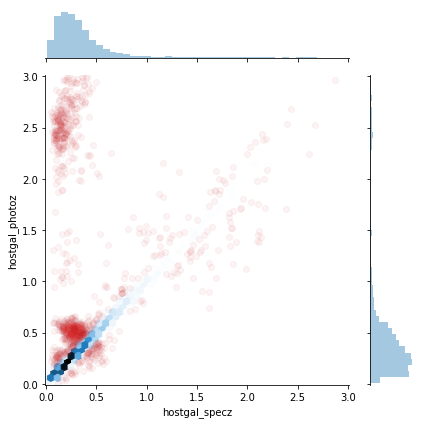

In [10]:
extragal = metadata['hostgal_specz'] != 0
g = sns.jointplot(metadata['hostgal_specz'][extragal],\
              metadata['hostgal_photoz'][extragal], kind='hex', \
              xlim=(-0.01, 3.01), ylim=(-0.01,3.01))#, height=8)

print(len(metadata['hostgal_specz'][extragal]))
len(metadata['hostgal_specz'])

outliers = np.abs(metadata['hostgal_specz'] - metadata['hostgal_photoz']) > 0.1
outliers = outliers & extragal
fig = g.fig
fig.axes[0].scatter(metadata['hostgal_specz'][outliers],\
                    metadata['hostgal_photoz'][outliers], color='C3', alpha=0.05)
fig.tight_layout()

print(np.sum(outliers))
print(np.sum(extragal))

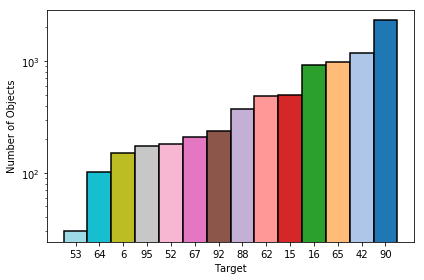

In [11]:
counts = Counter(metadata['target'])
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))
fig, ax = plt.subplots()

cmap = plt.cm.tab20
nlines = len(labels)
classcolor =  list(cmap(np.linspace(0,1,nlines)))[::-1]

# we'll create a mapping between class and color
classcolmap = dict(zip(labels, classcolor))

indexes = np.arange(nlines)
width = 1
ax.bar(indexes, values, width, edgecolor='k',\
       linewidth=1.5, tick_label=labels, log=True, color=classcolor)
ax.set_xlabel('Target')
ax.set_ylabel('Number of Objects')
fig.tight_layout()

In [12]:
#lcfilename = '../input/training_set.csv'
datadir = '/media/hayk/ecf060ce-bc56-4885-9176-43d514db6c66/pac'
lcfilename = os.path.join(datadir, 'training_set.csv')

lcdata = Table.read(lcfilename, format='csv')
lcdata[lcdata["object_id"] == 615]["mjd"].data.shape

(352,)

In [13]:
tsdict = OrderedDict()
for i in tnrange(nobjects, desc='Building Timeseries'):
    row = metadata[i]
    
    thisid = row["object_id"]
    target = row["target"]
    
    meta = {'z':row['hostgal_photoz'],\
            'zerr':row['hostgal_photoz_err'],\
            'mwebv':row['mwebv']}
    
    ind = (lcdata["object_id"] == thisid)
    thislc = lcdata[ind]
    
    pbind = [(thislc['passband'] == pb) for pb in pbmap]
    t = [thislc['mjd'][mask].data for mask in pbind ]
    m = [thislc['flux'][mask].data for mask in pbind ]
    e = [thislc['flux_err'][mask].data for mask in pbind ]
    
    tsdict[thisid] = TimeSeries(t=t, m=m, e=e,\
                        label=target, name=thisid, meta_features=meta,\
                        channel_names=pbnames )
del lcdata

In [14]:
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]

In [15]:
# we'll turn off warnings for a bit, because numpy can be whiny. 
import warnings
warnings.simplefilter('ignore')

In [16]:
def worker(tsobj):
    global features_to_use
    thisfeats = featurize.featurize_single_ts(tsobj,\
    features_to_use=features_to_use,
    raise_exceptions=False)
    return thisfeats

In [17]:
featuredir = './tmp'
featurefile = os.path.join(featuredir, "plasticc_featuretable.npz")
print (featurefile)
if os.path.exists(featurefile):
    featuretable, _ = featurize.load_featureset(featurefile)
else:
    features_list = []
    with tqdm_notebook(total=nobjects, desc="Computing Features") as pbar:
        with multiprocessing.Pool() as pool:  
            results = pool.imap(worker, list(tsdict.values()))
            for res in results:
                features_list.append(res)
                pbar.update()
            
    featuretable = featurize.assemble_featureset(features_list=features_list,\
                              time_series=tsdict.values())
    featurize.save_featureset(fset=featuretable, path=featurefile)


./tmp/plasticc_featuretable.npz


In [18]:
old_names = featuretable.columns.values
new_names = ['{}_{}'.format(x, pbmap.get(y,'meta')) for x,y in old_names]
cols = [featuretable[col] for col in old_names]
allfeats = Table(cols, names=new_names)
allfeats

<Table length=7848>
   amplitude_u        amplitude_g        amplitude_r     ...  z_meta zerr_meta
     float64            float64            float64       ... float64  float64 
------------------ ------------------ ------------------ ... ------- ---------
121.04801549999999         880.533203        646.9217225 ...     0.0       0.0
        14.6225035          10.422385           10.29848 ...  1.6267    0.2552
          4.701063          4.5430945         11.9217745 ...  0.2262    0.0157
         10.944189         97.9313515        111.4774825 ...  0.2813    1.1523
6.0678149999999995 19.896143000000002         54.3781135 ...  0.2415    0.0176
        37.7481335          5.3372295          2.9092535 ...     0.0       0.0
       141.6043155         726.110041        646.5527645 ...   0.182    0.0304
         4.4964645             5.0916          3.5223645 ...  0.7014      0.01
12.964479500000001         101.806106         117.792956 ...  0.3229     0.336
         7.1129255            3.57605         16.4874875 ...     0.0       0.0
               ...                ...                ... ...     ...       ...
        38.4512645        185.1234435 228.28410350000001 ...     0.0       0.0
        171.597851 143.51428650000003        114.3187325 ...  2.6113    0.9733
        12.4978815          7.0334825          28.123286 ...  0.0569    0.0248
11.608490999999999           4.611242         18.6337285 ...     0.0       0.0
         59.753473          33.927573          33.619944 ...     0.0       0.0
37.357845499999996  80.45925050000001         22.9596835 ...     0.0       0.0
147.04941349999999          28.318704          8.8461435 ...  2.5606    1.1146
        93.8776265         49.7077895 54.212563499999995 ...     0.0       0.0
          24.88684 163.77346400000002         16.9685295 ...     0.0       0.0
      3901.2680205       1677.6048965 15725.784383499999 ...     0.0       0.0

In [19]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
splits = list(splitter.split(allfeats, metadata['target']))[0]
train_ind, test_ind = splits


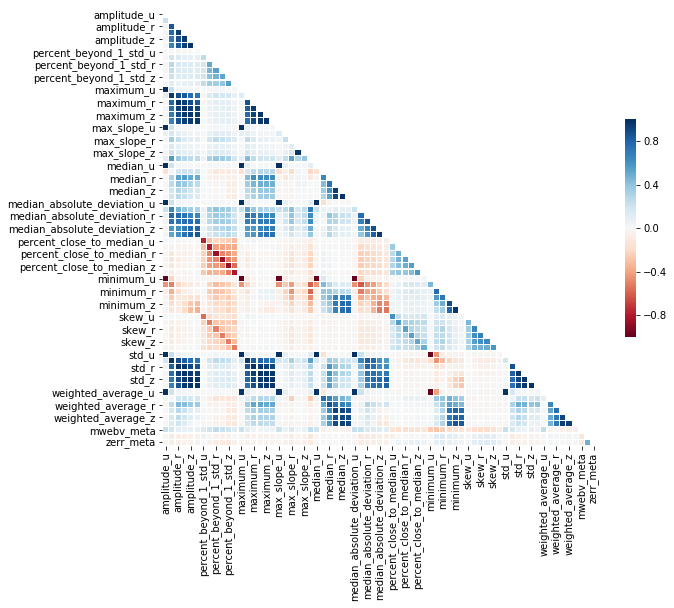

In [20]:
corr = allfeats.to_pandas().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
corr_plot = sns.heatmap(corr, mask=mask, cmap='RdBu', center=0,
                square=True, linewidths=.2, cbar_kws={"shrink": .5})

In [21]:
Xtrain = np.array(allfeats[train_ind].as_array().tolist())
Ytrain = np.array(metadata['target'][train_ind].tolist())

Xtest  = np.array(allfeats[test_ind].as_array().tolist())
Ytest  = np.array(metadata['target'][test_ind].tolist())

In [22]:
ncols = len(new_names)
npca  = (ncols  - 3)//len(pbnames)  + 3

In [23]:
pca = PCA(n_components=npca, whiten=True, svd_solver="full", random_state=42)
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

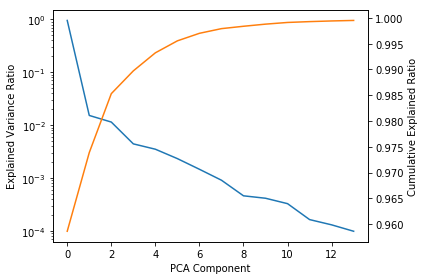

In [24]:
fig, ax = plt.subplots()
ax.plot(np.arange(npca), pca.explained_variance_ratio_, color='C0')
ax2 = ax.twinx()
ax2.plot(np.arange(npca), np.cumsum(pca.explained_variance_ratio_), color='C1')
ax.set_yscale('log')
ax.set_xlabel('PCA Component')
ax.set_ylabel('Explained Variance Ratio')
ax2.set_ylabel('Cumulative Explained Ratio')
fig.tight_layout()

In [25]:
clf = RandomForestClassifier(n_estimators=400, criterion='gini',\
                       oob_score=True, n_jobs=-1, random_state=42,\
                      verbose=1, class_weight='balanced', max_features='sqrt')


In [26]:
clf.fit(Xtrain_pca, Ytrain)
Ypred = clf.predict(Xtest_pca)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.1s finished


In [27]:
cm = confusion_matrix(Ytest, Ypred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

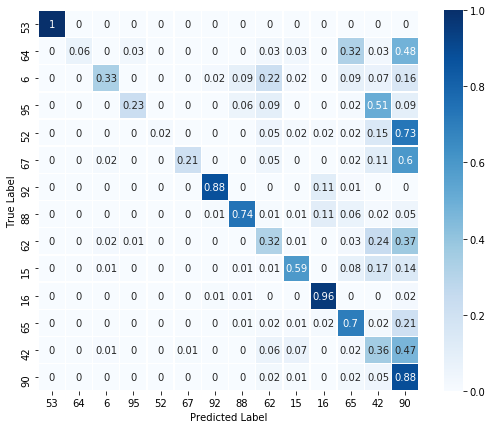

In [28]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')


In [39]:
Ypred = clf.predict_proba(Xtest_pca)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.2s finished


In [50]:
#class_names
preds_df = pd.DataFrame(Ypred, columns=labels)

#
preds_99 = np.ones(Ypred.shape[0])
preds_df[99] = preds_99 

In [55]:
Ypred.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])